# Figure 12 & 13: Gaussianity of residual noise

## 1. Imports

In [1]:
import pickle
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import seaborn as sns
import cmocean
color_map = cmocean.cm.ice

from applefy.utils.file_handling import open_fits
from applefy.gaussianity.residual_tests import extract_circular_annulus, gaussian_r2

from fours.utils.data_handling import read_fours_root_dir

## 2. Contrast curves

We need the contrast curves to determine the optimal choice of the method hyper-parameters for each dataset and separation from the star. 

(PCA components, 4S - $\lambda$)

In [2]:
root_dir = Path(read_fours_root_dir())
fake_planet_experiments_dir = root_dir / Path("70_results/x1_fake_planet_experiments/")

Data in the FOURS_ROOT_DIR found. Location: /fast/mbonse/s4


In [3]:
contrast_curves_file = fake_planet_experiments_dir / Path("contrast_curves/")

In [4]:
s4_keys = [
    "s4_median_lambda_000100",
    "s4_median_lambda_001000",
    "s4_median_lambda_010000",
    "s4_median_lambda_100000",
    "s4_mean_lambda_000100",
    "s4_mean_lambda_001000",
    "s4_mean_lambda_010000",
    "s4_mean_lambda_100000",
]

In [5]:
pca_results = dict()
s4_results = dict()

for tmp_file in contrast_curves_file.iterdir():
    if not tmp_file.name.endswith(".pkl"):
        continue
        
    tmp_datset_name = tmp_file.name[:-5]
    
    with open(tmp_file, 'rb') as f:
        tmp_data = pickle.load(f)
        
    # merge all data
    tmp_result_table = pd.concat(tmp_data.values(), keys=tmp_data.keys(), axis=1)
    pca_columns = tmp_result_table.columns.get_level_values(0).difference(s4_keys)
    
    # select results for PCA and S4
    pca_results[tmp_datset_name] = tmp_result_table[pca_columns]
    s4_results[tmp_datset_name] = tmp_result_table[s4_keys]
    
    # round the separation
    pca_results[tmp_datset_name].index  = np.round(pca_results[tmp_datset_name].index, 2)
    s4_results[tmp_datset_name].index  = np.round(s4_results[tmp_datset_name].index, 2)

## 3. Extract residual noise for two separations

In [6]:
# Note: Two datasets are removed from the list due to oversaturation close to the star
datasets = {
    "HD2262_305_199_C-0065_C": "HD 2262",
    "HD7570_331_1101_C-0092_C": "HD 7570",
    "HD11171_332_1101_C-0092_C": "HD 11171",
    "HD22049_351_096_C-0679_A": "HD 22049 (1)",
    "HD22049_303_199_C-0065_C": "HD 22049 (2)",
    "HD38678_331_084_C-0396_A": "HD 38678",
    "HD40136_333_1101_C-0092_C": "HD 40136",
    "HD115892_143_1101_C-0092_E": "HD 115892",
    "HD169022_140_1101_C-0092_E": "HD 169022",
}

In [7]:
def get_residual_noise(
        result_dict,  # PCA or 4S
        dataset_name,
        separation, 
        annulus_width=2.0):
    
    # 1.) Select dataset and find best hyperparameters
    result_table = result_dict[dataset_name]
    tmp_best_hyperparameters = result_table.idxmax(axis=1)[separation][0]
    print("The best hyper-parameter for " + dataset_name + ":")
    print(tmp_best_hyperparameters)
        
    # 2.) load the residual
    tmp_residual_file = fake_planet_experiments_dir / Path(dataset_name + \
        "_/residuals/" + tmp_best_hyperparameters + "/residual_ID_0000.fits")
    residual_frame = open_fits(tmp_residual_file)
    
    # 3.) Extract the noise
    _, positions, mask  = extract_circular_annulus(
        input_residual_frame=residual_frame,
        separation=separation,
        size_resolution_elements=3.6, # fwhm = 3.6
        annulus_width=annulus_width)

    selected_noise = residual_frame*mask
          
    return selected_noise

In [8]:
def get_r2_values(
    result_dict,  # PCA or 4S
    dataset_name,
    separation, 
    annulus_width=2.0):
    
    local_noise = get_residual_noise(
        result_dict,
        dataset_name,
        separation, 
        annulus_width)
    
    local_noise = local_noise[local_noise!=0]
    
    return gaussian_r2(local_noise, fit_method="theil sen")

In [9]:
def get_r2_sep(separation, width):
    all_results = []
    all_names = []
    dataset_keys = list(datasets.keys())
    
    for tmp_dataset, tmp_name in datasets.items():
        tmp_pca_r2 = get_r2_values(pca_results, tmp_dataset, separation, width)
        tmp_s4_r2 = get_r2_values(s4_results, tmp_dataset, separation, width)

        all_results.append((tmp_pca_r2, tmp_s4_r2))
        all_names.append(tmp_name)
        
    return np.array(all_results), all_names

## 4. Create the first plot

In [10]:
all_results_inner, names = get_r2_sep(3.5, 2.0)
all_results_outer, names = get_r2_sep(6.0, 2.0)

The best hyper-parameter for HD2262_305_199_C-0065_C:
stacked_05_PCA_050_components
The best hyper-parameter for HD2262_305_199_C-0065_C:
s4_mean_lambda_001000
The best hyper-parameter for HD7570_331_1101_C-0092_C:
stacked_05_PCA_020_components
The best hyper-parameter for HD7570_331_1101_C-0092_C:
s4_mean_lambda_010000
The best hyper-parameter for HD11171_332_1101_C-0092_C:
stacked_05_PCA_050_components
The best hyper-parameter for HD11171_332_1101_C-0092_C:
s4_median_lambda_001000
The best hyper-parameter for HD22049_351_096_C-0679_A:
stacked_05_PCA_080_components
The best hyper-parameter for HD22049_351_096_C-0679_A:
s4_mean_lambda_000100
The best hyper-parameter for HD22049_303_199_C-0065_C:
stacked_05_PCA_070_components
The best hyper-parameter for HD22049_303_199_C-0065_C:
s4_mean_lambda_000100
The best hyper-parameter for HD38678_331_084_C-0396_A:
stacked_05_PCA_070_components
The best hyper-parameter for HD38678_331_084_C-0396_A:
s4_median_lambda_001000
The best hyper-parameter

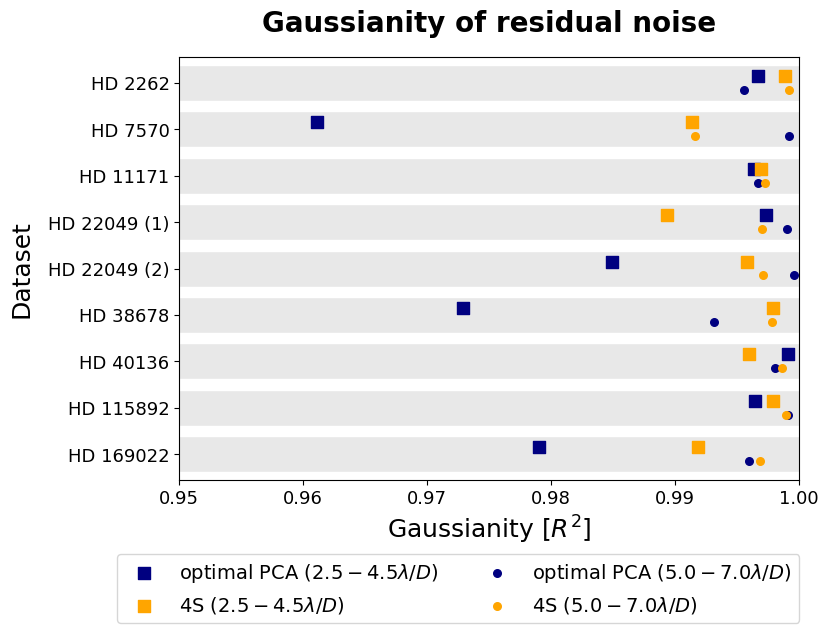

In [13]:
fig, axis = plt.subplots(1, 1, figsize=(8, 5.5))

offset = 0.15  # scatter inner and outer points

# Inner results
y_values_inner = np.arange(len(datasets))
axis.scatter(all_results_inner[::-1, 0], y_values_inner + offset,
             color="navy", marker="s", s=80,
             label="optimal PCA ($2.5 - 4.5 \lambda /D$)")

axis.scatter(all_results_inner[::-1, 1], y_values_inner + offset, 
             color="orange", marker="s", s=80,
             label="4S ($2.5 - 4.5 \lambda /D$)")

# Outer results
y_values_outer = np.arange(len(datasets))
axis.scatter(all_results_outer[::-1, 0], y_values_outer - offset, 
             color="navy", marker=".", s=120,
             label="optimal PCA ($5.0 - 7.0 \lambda /D$)")
axis.scatter(all_results_outer[::-1, 1], y_values_outer - offset,
             color="orange", marker=".", s=120,
             label="4S ($5.0 - 7.0 \lambda /D$)")

# Add Labels and titles
axis.set_xlabel("Gaussianity [$R^2$]", size=18,)
axis.set_ylabel("Dataset", size=18, labelpad=10)

axis.set_title("Gaussianity of residual noise", fontsize=20, fontweight="bold", y=1.04)

# Add legend
leg1 = axis.legend(
    bbox_to_anchor=(0.45, -0.36),
    fontsize=14, ncol=2,
    loc='lower center')

# Change tick size
axis.set_yticks(np.arange(len(datasets)), names[::-1])
axis.tick_params(
    axis='x', which='major', labelsize=13)
axis.tick_params(
    axis='y', which='major', labelsize=13)

# Set limit
axis.set_xlim(0.95, 1.0)
axis.hlines(np.arange(9), 0.95, 1.0, color="lightgray", alpha=0.5, lw=25, zorder=0)

fig.patch.set_facecolor('white')
plt.savefig("./final_plots/0a2_gaussianity_residual_noise.pdf", bbox_inches='tight')

## 5. Create a Plot with Examples

In [14]:
example_1 = "HD169022_140_1101_C-0092_E"
example_2 = "HD22049_303_199_C-0065_C"

In [15]:
def plot_QQ(axis_in,
            noise_pixel,
            color,
            label_name=None,
            add_r2=True):

    # unpack the results
    r2, tmp_linear_model, gaussian_samples = gaussian_r2(
            noise_samples=noise_pixel,
            fit_method="theil sen",
            return_fit=True)

    # Plot the Q-Q points
    axis_in.scatter(sorted(gaussian_samples),
                    sorted(noise_pixel), 
                    s=20,
                    color=color)
    #axis_in.grid()

    # Plot the fit model
    x = np.linspace(-5, 5, 100)
    axis_in.plot(x, tmp_linear_model.predict(x.reshape(-1, 1)),
                 'grey', lw=2, alpha=0.5)

    # Set the axis limits
    axis_in.set_xlim(np.min(gaussian_samples)*1.3,
                     np.max(gaussian_samples)*1.3)

    margin = np.max([np.abs(np.min(noise_pixel)*0.2),
                     np.abs(np.max(noise_pixel)*0.2)])
    axis_in.set_ylim(np.min(noise_pixel) - margin,
                     np.max(noise_pixel) + margin)

    # Add additional information if needed
    if add_r2:
        text = r"$R^2 = $" + "%0.3f"%r2
        axis_in.text(0.7, 0.08, text, ha="center",
                     fontsize=10,
                     transform = axis_in.transAxes,
                 bbox={"fc":"white", "ec":"white"})

    # Set the axis labels and make the plot quadratic
    axis_in.set_aspect(1.0/axis_in.get_data_ratio(), adjustable='box')
    axis_in.set_xlabel("Expected \n normal values", fontsize=10)

    axis_in.tick_params(axis='both', which='major', labelsize=8)

In [16]:
def remove_image_ticks(axis_in):
    axis_in.set_xticks([]) 
    axis_in.set_yticks([]) 

In [17]:
def plot_example(basis_in, example_name):
    residual_frame_pca = get_residual_noise(
        pca_results, example_name, 3.5, 2.0)
    residual_frame_s4 = get_residual_noise(
        s4_results, example_name, 3.5, 2.0)
    
    gs1 = gridspec.GridSpecFromSubplotSpec(
        2, 2, subplot_spec = basis_in,
        hspace=0.1,
        wspace=0.13)

    axis_pca_qq = fig.add_subplot(gs1[1, 0])
    axis_s4_qq = fig.add_subplot(gs1[1, 1])
    axis_pca_residual = fig.add_subplot(gs1[0, 0])
    axis_s4_residual = fig.add_subplot(gs1[0, 1])

    plot_QQ(axis_pca_qq, residual_frame_pca[residual_frame_pca!=0], color="navy")
    plot_QQ(axis_s4_qq, residual_frame_s4[residual_frame_s4!=0], color="orange")
    
    axis_pca_qq.set_ylabel("Observations", fontsize=10)

    axis_pca_residual.imshow(
        residual_frame_pca[24:-24, 24:-24],
        cmap=color_map, origin='lower')

    remove_image_ticks(axis_pca_residual)

    axis_s4_residual.imshow(
        residual_frame_s4[24:-24, 24:-24], 
        cmap=color_map, origin='lower')

    remove_image_ticks(axis_s4_residual)
    
    axis_pca_residual.set_title("Optimal PCA", fontsize=11)
    axis_s4_residual.set_title("4S", fontsize=12)
    
    return axis_pca_residual, axis_s4_residual

The best hyper-parameter for HD169022_140_1101_C-0092_E:
stacked_05_PCA_016_components
The best hyper-parameter for HD169022_140_1101_C-0092_E:
s4_mean_lambda_000100
The best hyper-parameter for HD22049_303_199_C-0065_C:
stacked_05_PCA_070_components
The best hyper-parameter for HD22049_303_199_C-0065_C:
s4_mean_lambda_000100


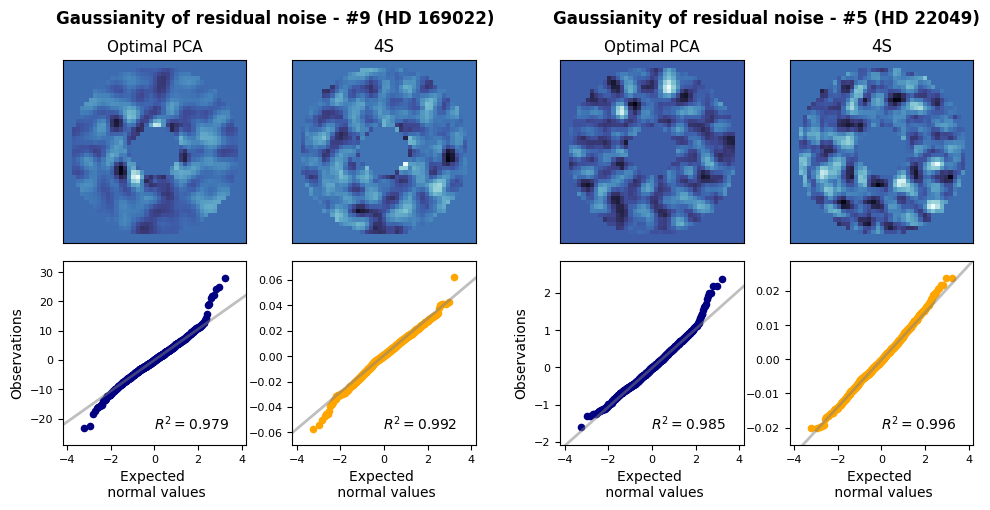

In [18]:
# 1.) Create Plot Layout
fig = plt.figure(constrained_layout=False, figsize=(12, 5.))
gs0 = fig.add_gridspec(
    1, 2,
    hspace=0.0,
    wspace=0.15)

pca_ax, s4_ax = plot_example(gs0[0], example_1)
plot_example(gs0[1], example_2)

text1 = fig.text(0.31, 0.98, 'Gaussianity of residual noise - #9 (HD 169022)', 
         ha='center', va='top', fontsize=12, fontweight="bold")
text2 = fig.text(0.72, 0.98, 'Gaussianity of residual noise - #5 (HD 22049)', 
         ha='center', va='top', fontsize=12, fontweight="bold")

fig.patch.set_facecolor('white')
plt.savefig("./final_plots/0a1_gaussianity_residual_noise.pdf", bbox_inches='tight')